先引入基础类

In [128]:
import numpy as np
import matplotlib.pyplot as plt

定义BernolliBandit问题的类

In [129]:
class BernoulliBandit:
    def __init__(self, K):
        self.probs = np.random.uniform(size = K)  # probabilities of winning of each arm  
        self.best_idx = np.argmax(self.probs)     # index of the best arm
        self.best_prob = self.probs[self.best_idx]
        self.K = K                                # number of arms

    def step(self, k):
        """
        Simulate pulling the k-th arm of the bandit.
        Returns 1 if the arm wins, 0 otherwise.
        """
        return np.random.binomial(1, self.probs[k])

定义一个10臂老虎机

In [130]:
np.random.seed(1)
K = 10
bandit_10_arm = BernoulliBandit(K)
print("Generated a Bernolli Bandit with %d arms." %K)
print("The best arm is %d with a probability of %.4f." %(bandit_10_arm.best_idx, bandit_10_arm.best_prob))

Generated a Bernolli Bandit with 10 arms.
The best arm is 1 with a probability of 0.7203.


定义基础算法类，下面的几种算法都继承了该类

估计期望奖励 $\hat{Q}(a_t)$ 更新公式：
$$
\hat{Q}(a_t) = \hat{Q}(a_t) + \frac{1}{N(a_t)} (r_t - \hat{Q}(a_t))
$$
其中，$r_t$为奖励，$N(a_t)$为拉动拉杆的总次数counts

In [131]:
class Solver:
    """
    basic solver for the Bernoulli bandit problem
    """
    def __init__(self, bandit):                # bandit是BernulliBandit类的实例
        self.bandit = bandit
        self.counts = np.zeros(self.bandit.K)  # number of times each arm has been pulled
        self.regret = 0
        self.actions = []
        self.regrets = []

    def update_regret(self, k):
        """k is the index of the arm pulled"""
        self.regret += self.bandit.best_prob - self.bandit.probs[k]
        self.regrets.append(self.regret)
    
    def run_one_step(self):
        """This method should be implemented by subclasses"""
        raise NotImplementedError("This method should be implemented by subclasses")
    
    def run(self, num_steps):
        """Run the bandit for a given number of steps"""
        for _ in range(num_steps):
            k = self.run_one_step()
            self.counts[k] += 1
            self.actions.append(k)
            self.update_regret(k)

定义绘图函数，可视化每一时间步的累计懊悔

In [132]:
def plot_results(solvers, solver_names):
    """生成累积懊悔随时间变化的图像。输入solvers是一个列表,列表中的每个元素是一种特定的策略。
    而solver_names也是一个列表,存储每个策略的名称"""
    for idx, solver in enumerate(solvers):
        time_list = range(len(solver.regrets))
        plt.plot(time_list, solver.regrets, label=solver_names[idx])
    plt.xlabel('Time steps')
    plt.ylabel('Cumulative regrets')
    plt.title('%d-armed bandit' % solvers[0].bandit.K)
    plt.legend()
    plt.show()

**算法1**：$\epsilon$-贪心算法

特征：$\epsilon$ 的大小决定了累计懊悔的线性增长速度，二者成正相关；

epsilon-贪婪算法1的累积懊悔为： 27.33766831001272
epsilon-贪婪算法2的累积懊悔为： 219.05987100412844


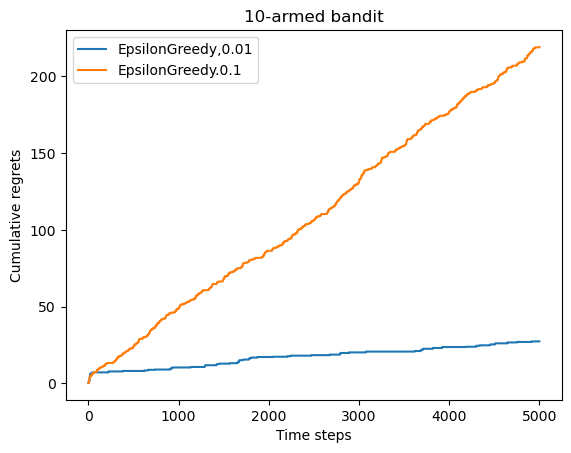

In [133]:
class EpsilonGreedy(Solver):
    """
    Explaination: The solver has epsi prob to randomly choose other actions alongside the current action, 
                  that is, the action that maximizes Q function (argmax(Q(a_t)))
    """
    def __init__(self, bandit, epsilon = 0.01, init_prob = 1.0):
        super(EpsilonGreedy, self).__init__(bandit)
        self.epsilon = epsilon
        # intial estimates of Q(a_t)
        self.estimates = np.array([init_prob] * self.bandit.K)
    
    def run_one_step(self):
        if np.random.random() < self.epsilon:
            k = np.random.randint(0, self.bandit.K)
        else:
            k = np.argmax(self.estimates)
        r = self.bandit.step(k)  # reward of this step
        # update Q(a_t)
        self.estimates[k] += 1. / (self.counts[k] + 1) * (r - self.estimates[k])
        return k 

np.random.seed(1)  
epsilon_greedy_solver1 = EpsilonGreedy(bandit_10_arm, epsilon=0.01)
epsilon_greedy_solver2 = EpsilonGreedy(bandit_10_arm, epsilon=0.1)
epsilon_greedy_solver1.run(5000)
epsilon_greedy_solver2.run(5000)
print('epsilon-贪婪算法1的累积懊悔为：', epsilon_greedy_solver1.regret)
print('epsilon-贪婪算法2的累积懊悔为：', epsilon_greedy_solver2.regret)
plot_results([epsilon_greedy_solver1, epsilon_greedy_solver2], ["EpsilonGreedy,0.01", "EpsilonGreedy.0.1"])

**算法2**：衰减 $\epsilon$-贪心算法

特征：$\epsilon$ 随时间衰减，算法为“sublinear”，优于算法1

epsilon值衰减的贪婪算法的累积懊悔为： 8.295411472612818


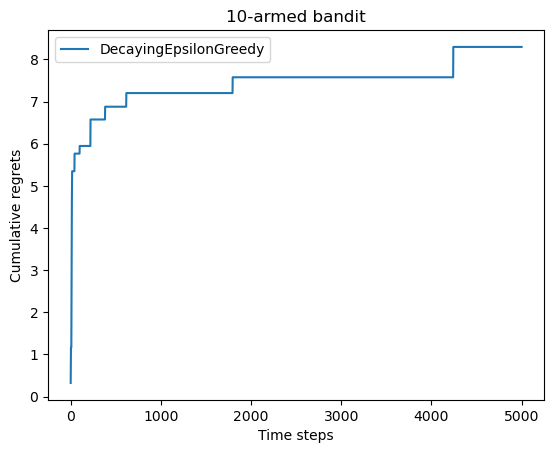

In [134]:
class DecayingEpsilonGreedy(Solver):
    """
    EpsilonGreedy with decaying epsilon
    """
    def __init__(self, bandit, init_prob = 1.0):
        super(DecayingEpsilonGreedy, self).__init__(bandit)
        self.estimates = np.array([init_prob] * self.bandit.K)
        self.total_count = 0

    def run_one_step(self):
        self.total_count += 1
        if np.random.random() < 1 / self.total_count:
            k = np.random.randint(0, self.bandit.K)
        else:
            k = np.argmax(self.estimates)
        r = self.bandit.step(k)
        # update Q(a_t)
        self.estimates[k] += 1. / (self.counts[k] + 1) * (r - self.estimates[k])
        return k
    
np.random.seed(1)
decaying_epsilon_greedy_solver = DecayingEpsilonGreedy(bandit_10_arm)
decaying_epsilon_greedy_solver.run(5000)
print('epsilon值衰减的贪婪算法的累积懊悔为：', decaying_epsilon_greedy_solver.regret)
plot_results([decaying_epsilon_greedy_solver], ["DecayingEpsilonGreedy"])

**算法3** 上置信界算法（UCB）

上置信界（upper confidence bound，UCB）算法是一种经典的基于不确定性的策略算法，它的思想用到了一个非常著名的数学原理：**霍夫丁不等式**（Hoeffding's inequality）。

在霍夫丁不等式中，令$X_1,\ldots,X_n$为$n$个独立同分布的随机变量，取值范围为[0,1],其经验期望为$\bar{x}_n=\frac1n\sum_{j=1}^nX_j$,则有
$$\mathbb{P}\left\{\mathbb{E}\left[X\right]\geq\bar{x}_n+u\right\}\leq e^{-2nu^2}$$

现在我们将霍夫丁不等式运用于多臂老虎机问题中。将$\hat{Q}_t(a)$ 代入$\bar{x}_t$,不等式中的参数$u=\hat{U}_t(a)$代表不确定性度量。给定一个概率$p=e^{-2N_t(a)U_t(a)^2}$,根据上述不等式，$Q_t(a)<\hat{Q}_t(a)+\hat{U}_t(a)$ 至少以概率 $1-p$ 成立。当$p$很小时，
$Q_t(a)<\hat{Q}_t(a)+\hat{U}_t(a)$就以很大概率成立，$\hat{Q}_t(a)+\hat{U}_t(a)$便是期望奖励上界。此时，上置信界算法便选取期望奖励上界最大的动作，即$a=\underset{a\in\mathcal{A}}{\operatorname*{\operatorname*{\arg\max}}}\left[\hat{Q}(a)+\underline{U}(a)\right]$ 。那其中$\hat{U}_t(a)$具体是什么呢？根据等式$e^{-2N_t(a)U_t(a)^2}$,解之即得$\hat{U}_t(a)=\sqrt{\frac{-\log p}{2N_t(a)}}$ 。因此，设定一个概率$p$后，就可以计算相应的不确定性度量$\hat{U}_t(a)$了。更直观地说， UCB 算法在每次选择拉杆前，先估计每根拉杆的期望奖励的上界，使得拉动每根拉杆的期望奖励只有一个较小的概率$p$超过这个上界，接着选出期望奖励上界最大的拉杆， 从而选择最有可能获得最大期望奖励的拉杆。
我们编写代码来实现 UCB 算法，并且仍然使用 2.2.4 节定义的 10 臂老虎机来观察实验结果。在具体的实现过程中，设置$p=\frac1t$,并且在分母中为拉动每根拉杆的次数加上常数 1,以免出现分母为 0 的情形，即此时$\hat{U}_t(a)=\sqrt{\frac{\log t}{2(N_t(a)+1)}}$。同时，我们设定一个系数$c$来控制不确定性的比重，此时$a=\arg\max_{a\in\mathcal{A}}\hat{Q}(a)+c\cdot\hat{U}(a)$。


上置信界算法的累积懊悔为： 87.0943533409013


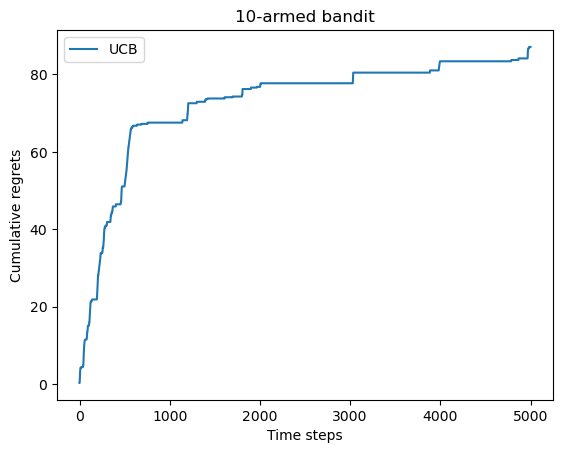

In [135]:
class UCB(Solver):
    def __init__(self, bandit, coef, init_prob = 1.0):
        super(UCB, self).__init__(bandit)
        self.total_count = 0
        self.estimates = np.array([init_prob] * self.bandit.K)
        # coef的含义为不确定性的比重
        self.coef = coef

    def run_one_step(self):
        self.total_count += 1
        ucb = self.estimates + self.coef * np.sqrt(
            np.log(self.total_count) / (2 * (self.counts + 1)))  # 计算上置信界
        k = np.argmax(ucb)  # 选出上置信界最大的拉杆
        r = self.bandit.step(k)
        self.estimates[k] += 1. / (self.counts[k] + 1) * (r - self.estimates[k])
        return k
    
np.random.seed(1)
coef = 1  # 控制不确定性比重的系数
UCB_solver = UCB(bandit_10_arm, coef)
UCB_solver.run(5000)
print('上置信界算法的累积懊悔为：', UCB_solver.regret)
plot_results([UCB_solver], ["UCB"])

**算法4** 汤普森采样

先假设拉动每根拉杆的奖励服从一个特定的概率分布，然后根据拉动每根拉杆的期望奖励来进行选择。但是由于计算所有拉杆的期望奖励的代价比较高，汤普森采样算法使用采样的方式，即根据当前每个动作 $a$ 的奖励概率分布进行一轮采样，得到一组各根拉杆的奖励样本，再选择样本中奖励最大的动作。可以看出，汤普森采样是一种计算所有拉杆的最高奖励概率的蒙特卡洛采样方法。

了解了汤晋森采样算法的基本思路后，我们需要解决另一个问题：怎样得到当前每个
动作$a$的奖励概率分布并且在过程中进行更新？在实际情况中，我们通常用 Beta 分布对当前每个动作的奖励概率分布进行建模。具体来说，若某拉杆被选择了$k$ 次，其中$m_1$次奖励为 1, $m_2$次奖励为 0,则该拉杆的奖励服从参数为$(m_1+1,m_2+1)$的Beta 分布

汤普森采样算法的累积懊悔为： 54.887390260274515


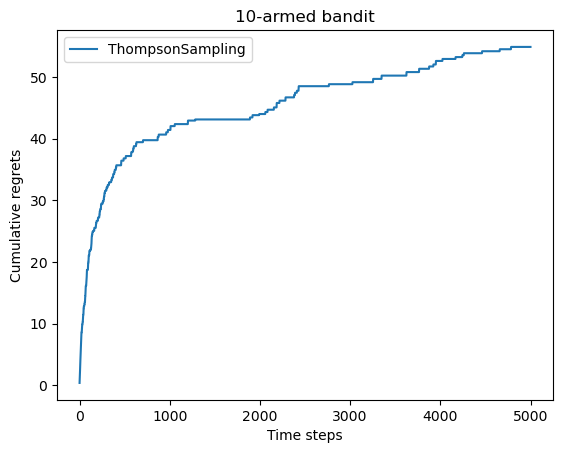

In [136]:
class ThompsonSampling(Solver):
    """ 汤普森采样算法,继承Solver类 """
    def __init__(self, bandit):
        super(ThompsonSampling, self).__init__(bandit)
        self._a = np.ones(self.bandit.K)  # 列表,表示每根拉杆奖励为1的次数
        self._b = np.ones(self.bandit.K)  # 列表,表示每根拉杆奖励为0的次数

    def run_one_step(self):
        samples = np.random.beta(self._a, self._b)  # 按照Beta分布采样一组奖励样本
        k = np.argmax(samples)  # 选出采样奖励最大的拉杆
        r = self.bandit.step(k)

        self._a[k] += r  # 更新Beta分布的第一个参数
        self._b[k] += (1 - r)  # 更新Beta分布的第二个参数
        return k


np.random.seed(1)
thompson_sampling_solver = ThompsonSampling(bandit_10_arm)
thompson_sampling_solver.run(5000)
print('汤普森采样算法的累积懊悔为：', thompson_sampling_solver.regret)
plot_results([thompson_sampling_solver], ["ThompsonSampling"])

通过实验我们可以得到以下结论：$\epsilon$贪婪算法的累积懊海是随时间线性增长的，而另外3种算法($\epsilon$-衰减贪婪算法、上置信界算法、汤普森采样算法)的累积懊悔都是随时间次线性增长的(具体为对数形式增长)。

多臂老虎机问题(MAB)与强化学习的一大区别在于其与环境的交互并不会改变环境，即多臂老虎机的每次交互的结果和以往的动作无关，所以可看作无状态的强化学习（stateless reinforcement learning）。